**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: Operaciones de Aprendizaje Automático**

Tecnológico de Monterrey

**Fase 1 – Procesamiento y Modelado Inicial**
En esta primera etapa aprenderás a trabajar con los datos y a construir tus primeros modelos:

* Realizar un análisis del problema y generar una propuesta de valor.
* Manipular y preparar datos.
* Explorar y preprocesar información.
* Aplicar técnicas de versionado para asegurar reproducibilidad y trazabilidad.
* Construir, ajustar y evaluar modelos de Machine Learning.

---

**EQUIPO 10**

**ALUMNOS:**

Gabriela Lizeth Moreno Hernández - AXXXXX

Alejandro Chávez Campos  -  AXXXXX

Carlos Armando Alcántar Sánchez - A01311747

Luis Fernando Caporal Montes de Oca  -  A01795898

Yamil Abraham Nechar Reyes - A01795726

# Caravan Insurance

Dataset proporcionado por la compañía holandesa de minería de datos Sentient Machine Research. El objetivo principal es predecir qué clientes tienen una póliza de seguro para caravanas.

### Características principales:

* Fuente: Datos de clientes reales, anonimizados y preparados para una competición de minería de datos.

* Volumen: Contiene información de más de 9.000 clientes en total.

* Variables: Cada cliente se describe mediante 86 atributos.

Tipos de Datos:

* **Datos Sociodemográficos (Atributos 1-43)**: Información derivada de los códigos postales de los clientes. Todos los residentes de una misma zona postal comparten estos mismos atributos (ej. porcentaje de hogares alquilados, distribución por nivel de ingresos, etc.).

* **Datos de Uso de Productos** (Atributos 44-86): Reflejan la posesión o uso de otros productos y servicios por parte del cliente.

* **Variable Objetivo:** El atributo 86, "CARAVAN: Number of mobile home policies", indica si un cliente tiene o no un seguro de caravana.

### Estructura de los Archivos:

El proyecto se divide en tres archivos con campos separados por tabuladores:

##### TICDATA2000.txt (Conjunto de Entrenamiento):

Registros: 5.822 clientes.

Contenido: Incluye los 86 atributos completos, incluida la variable objetivo. Se utiliza para desarrollar, entrenar y validar los modelos predictivos.

##### TICEVAL2000.txt (Conjunto de Evaluación):

Registros: 4.000 clientes.

Contenido: Tiene el mismo formato que el archivo de entrenamiento, pero no incluye la variable objetivo. Este archivo se utiliza para realizar las predicciones finales con el modelo ya construido.

#####  TICTGTS2000.txt (Soluciones del Conjunto de Evaluación):

Contenido: Contiene las respuestas reales (targets) para los 4.000 clientes del conjunto de evaluación. Solo los organizadores tenían esta información, permitiendo así la evaluación objetiva de las predicciones realizadas por los participantes.

Nota Importante: Todas las variables cuyo nombre comienza por "M" son variables de código postal que proporcionan información sobre la distribución de una característica específica en el área de residencia del cliente.

In [3]:
# --- Librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import pointbiserialr
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from pycaret.classification import predict_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pycaret.classification import setup, compare_models
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import os

# Configuración de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [4]:
os.chdir("..")  # subir al nivel raíz del proyecto

!pwd  # verificar ruta actual
!dvc pull data/processed/insurance_company_processed_data.csv.dvc

os.chdir("notebooks")

/Users/luisfernandocaporalmontesdeoca/Documents/MNA-V Tec de Monterrey/MLOps/MNA_MLOps_Equipo12_backup
Fetching
!
  0% Checking cache in '/Users/luisfernandocaporalmontesdeoca/Documents/MNA-V Te
Fetching                                                                        
Building workspace index                              |3.00 [00:00,  558entry/s]
Comparing indexes                                    |4.00 [00:00, 1.78kentry/s]
Applying changes                                      |0.00 [00:00,     ?file/s]
Everything is up to date.


## Carga de datos

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

file_name = '../data/raw/insurance_company_original.csv'

df = pd.read_csv(file_name)
df.head()

,PD_0,PD_1,PD_2,PD_3,PD_4,PD_5,PD_6,PD_7,PD_8,PD_9,PD_11,PD_12,PD_13,PD_14,PD_15,PD_16,PD_17,PD_18,PD_19,PD_22,PD_24,PD_25,PD_26,PD_27,PD_29,PD_30,PD_31,PD_32,PD_33,PD_35,PD_36,PD_37,PD_38,PD_39,PD_40,PD_41,target,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,zone_11,zone_12,zone_13,zone_14,zone_15,zone_16,zone_17,zone_18,zone_19,zone_20,zone_21,zone_22,zone_23,zone_24,zone_25,zone_26,zone_27,zone_28,zone_29,zone_30,zone_31,zone_32,zone_33,zone_34,zone_35,zone_36,zone_37,zone_38,zone_39,zone_40,zone_41,zone_42,zone_43,zone_44,zone_45,zone_46,zone_47,zone_48,zone_49,zone_50,zone_51,zone_52,zone_53,zone_54,zone_55,zone_56,zone_57,zone_58,zone_59,zone_60,zone_61,zone_62,zone_63,zone_64,zone_65,zone_66,zone_67,zone_68,zone_69,zone_70,zone_71,zone_72,zone_73,zone_74,zone_75,zone_76,zone_77,zone_78,zone_79,zone_80,zone_81,zone_82,zone_83,zone_84,zone_85,zone_86,zone_87,zone_88,zone_89,zone_90,zone_91,zone_92,zone_93,zone_94,zone_95,zone_96,zone_97,zone_98,zone_99,zone_100,zone_101,zone_102,zone_103,zone_104,zone_105,zone_106,zone_107,zone_108,zone_109,zone_110,zone_111,zone_112,zone_113,zone_114,zone_115,zone_116,zone_117,zone_118,zone_119,zone_120,zone_121,zone_122,zone_123,zone_124,zone_125,zone_126,zone_127,zone_128,zone_129,zone_130,zone_131,zone_132,zone_133,zone_134,zone_135,zone_136,zone_137,zone_138,zone_139,zone_140,zone_141,zone_142,zone_143,zone_144,zone_145,zone_146,zone_147,zone_148,zone_149,zone_150,zone_151,zone_152,zone_153,zone_154,zone_155,zone_156,zone_157,zone_158,zone_159,zone_160,zone_161,zone_162,zone_163,zone_164,zone_165,zone_166,zone_167,zone_168,zone_169,zone_170,zone_171,zone_172,zone_173,zone_174,zone_175,zone_176,zone_177,zone_178,zone_179,zone_180,zone_181,zone_182,zone_183,zone_184,zone_185,zone_186,zone_187,zone_188,zone_189,zone_190,zone_191,zone_192,zone_193,zone_194,zone_195,zone_196,zone_197,zone_198,zone_199,zone_200,zone_201,zone_202,zone_203,zone_204,zone_205,zone_206,zone_207,zone_208,zone_209,zone_210,zone_211,zone_212,zone_213,zone_214,zone_215,zone_216,zone_217,zone_218,zone_219,zone_220,zone_221,zone_222,zone_223,zone_224,zone_225,zone_226,zone_227,zone_228,zone_229,zone_230,zone_231,zone_232,zone_233,zone_234,zone_235,zone_236,zone_237,zone_238,zone_239,zone_240,zone_241,zone_242,zone_243,zone_244,zone_245,zone_246,zone_247,zone_248,zone_249,zone_250,zone_251,zone_252,zone_253,zone_254,zone_255,zone_256,zone_257,zone_258,zone_259,zone_260,zone_261,zone_262,zone_263,zone_264,zone_265,zone_266,zone_267,zone_268,zone_269,zone_270,zone_271,zone_272,zone_273,zone_274,zone_275,zone_276,zone_277,zone_278,zone_279,zone_280,zone_281,zone_282,zone_283,zone_284,zone_285,zone_286,zone_287,zone_288,zone_289,zone_290,zone_291,zone_292,zone_293,zone_294,zone_295,zone_296,zone_297,zone_298,zone_299,zone_300,zone_301,zone_302,zone_303,zone_304,zone_305,zone_306,zone_307,zone_308,zone_309,zone_310,zone_311,zone_312,zone_313,zone_314,zone_315,zone_316,zone_317,zone_318,zone_319,zone_320,zone_321,zone_322,zone_323,zone_324,zone_325,zone_326,zone_327,zone_328,zone_329,zone_330,zone_331,zone_332,zone_333,zone_334,zone_335,zone_336,zone_337,zone_338,zone_339,zone_340,zone_341,zone_342,zone_343,zone_344,zone_345,zone_346,zone_347,zone_348,zone_349,zone_350,zone_351,zone_352,zone_353,zone_354,zone_355,zone_356,zone_357,zone_358,zone_359,zone_360,zone_361,zone_362,zone_363,zone_364,zone_365,zone_366,zone_367,zone_368,zone_369,zone_370,zone_371,zone_372,zone_373,zone_374,zone_375,zone_376,zone_377,zone_378,zone_379,zone_380,zone_381,zone_382,zone_383,zone_384,zone_385,zone_386,zone_387,zone_388,zone_389,zone_390,zone_391,zone_392,zone_393,zone_394,zone_395,zone_396,zone_397,zone_398,zone_399,zone_400,zone_401,zone_402,zone_403,zone_404,zone_405,zone_406,zone_407,zone_408,zone_409,zone_410,zone_411,zone_412,zone_413,zone_414,zone_415,zone_416,zone_417,zone_418,zone_419,zone_420,zone_421,zone_422,zone_423,zone_424,zone_425,zone_426,zone_427,zone_428,zone_429,zone_430,zone_431,zone_432,zone_4

1.2 Información General del Dataset

# Split de datos para entrenamiento y testeo

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42  # stratify para clasificación
)

# Iteración de diversos modelos con librerías de AutoML

In [4]:
df_final = X_train.copy()
df_final['target'] = y_train


In [5]:
import h2o
from h2o.automl import H2OAutoML

# Inicializar H2O
h2o.init()

# Convertir datos a formato H2O
h2o_df = h2o.H2OFrame(df_final)
h2o_df['target'] = h2o_df['target'].asfactor()  # Importante: target como factor

# Configurar AutoML
aml = H2OAutoML(
    max_models=20,
    seed=42,
    max_runtime_secs=300,  # 5 minutos
    balance_classes=True,   # Para datos desbalanceados
    stopping_metric="AUC"
)

# Entrenar
aml.train(y='target', training_frame=h2o_df)

# Ver líderboard
lb = aml.leaderboard
print(lb.head())

# Obtener el mejor modelo
best_h2o_model = aml.leader

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 12 hours 51 mins
H2O_cluster_timezone:,America/Mexico_City
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_luis_caporal_03o5et
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.494 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
13:57:52.587: _train param, Dropping bad and constant columns: [zone_200, zone_321, zone_1068, zone_560, zone_677, zone_313, zone_433, zone_553, zone_795, zone_1181, zone_438, zone_559, zone_679, zone_8, zone_1637, zone_1075, zone_1078, zone_574, zone_210, zone_452, zone_330, zone_450, zone_687, zone_686, zone_329, zone_1071, zone_449, zone_1073, zone_689, zone_1074, zone_1721, zone_1604, zone_1727, zone_1285, zone_1286, zone_222, zone_100, zone_1169, zone_215, zone_458, zone_1612, zone_1733, zone_1616, zone_112, zone_232, zone_473, zone_226, zone_468, zone_465, zone_1290, zone_109, zone_108, zone_229, zone_348, zone_1294, zone_902, zone_907, zone_1706, zone_1384, zone_1143, zone_1264, zone_881, zone_1025, zone_758, zone_1380, zone_756, zone_639, zone_638, zone_1274, zone_1276, zone_44, zone_651, zone_1156, zone_1398, zone_890, zone_401, zone_526, zone_647, zone_403, zone_5

██
13:58:05.658: _train param, Dropping bad and constant columns: [zone_200, zone_321, zone_1068, zone_560, zone_677, zone_313, zone_433, zone_553, zone_795, zone_1181, zone_438, zone_559, zone_679, zone_8, zone_1637, zone_1075, zone_1078, zone_574, zone_210, zone_452, zone_330, zone_450, zone_687, zone_686, zone_329, zone_1071, zone_449, zone_1073, zone_689, zone_1074, zone_1721, zone_1604, zone_1727, zone_1285, zone_1286, zone_222, zone_100, zone_1169, zone_215, zone_458, zone_1612, zone_1733, zone_1616, zone_112, zone_232, zone_473, zone_226, zone_468, zone_465, zone_1290, zone_109, zone_108, zone_229, zone_348, zone_1294, zone_902, zone_907, zone_1706, zone_1384, zone_1143, zone_1264, zone_881, zone_1025, zone_758, zone_1380, zone_756, zone_639, zone_638, zone_1274, zone_1276, zone_44, zone_651, zone_1156, zone_1398, zone_890, zone_401, zone_526, zone_647, zone_403, zone_529, zone_528, zone_1006, zone_1248, zone_1008, zone_1120, zone_1000, zone_12, zone_540, zone_782, zone_1487, zo


13:58:26.748: _train param, Dropping bad and constant columns: [zone_200, zone_321, zone_1068, zone_560, zone_677, zone_313, zone_433, zone_553, zone_795, zone_1181, zone_438, zone_559, zone_679, zone_8, zone_1637, zone_1075, zone_1078, zone_574, zone_210, zone_452, zone_330, zone_450, zone_687, zone_686, zone_329, zone_1071, zone_449, zone_1073, zone_689, zone_1074, zone_1721, zone_1604, zone_1727, zone_1285, zone_1286, zone_222, zone_100, zone_1169, zone_215, zone_458, zone_1612, zone_1733, zone_1616, zone_112, zone_232, zone_473, zone_226, zone_468, zone_465, zone_1290, zone_109, zone_108, zone_229, zone_348, zone_1294, zone_902, zone_907, zone_1706, zone_1384, zone_1143, zone_1264, zone_881, zone_1025, zone_758, zone_1380, zone_756, zone_639, zone_638, zone_1274, zone_1276, zone_44, zone_651, zone_1156, zone_1398, zone_890, zone_401, zone_526, zone_647, zone_403, zone_529, zone_528, zone_1006, zone_1248, zone_1008, zone_1120, zone_1000, zone_12, zone_540, zone_782, zone_1487, zone

███████████| (done) 100%
model_id                                                       auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_BestOfFamily_1_AutoML_13_20251107_135752  0.758735   0.203032  0.172794                0.365753  0.230572  0.0531637
GBM_4_AutoML_13_20251107_135752                           0.748139   0.220445  0.141748                0.344144  0.23425   0.0548729
GBM_grid_1_AutoML_13_20251107_135752_model_2              0.744645   0.215743  0.178581                0.359904  0.23302   0.0542983
GBM_3_AutoML_13_20251107_135752                           0.739822   0.212531  0.168808                0.330207  0.23297   0.0542751
GBM_2_AutoML_13_20251107_135752                           0.738797   0.21018   0.177939                0.334612  0.232341  0.0539825
GBM_5_AutoML_13_20251107_135752                           0.738265   0.210971  0.122327                0.32508   0.233247  0.0544043
StackedEnsemble_AllModels_1_AutoML_13_202511

In [6]:
# Performance en el dataset de entrenamiento
performance = best_h2o_model.model_performance(h2o_df)
print(performance)

# Métricas específicas
print(f"AUC: {performance.auc()}")
print(f"Precision: {performance.precision()}")
print(f"Recall: {performance.recall()}")
print(f"F1: {performance.F1()}")

# Matriz de confusión
print("\nMatriz de Confusión:")
print(performance.confusion_matrix())

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.04432401495261299
RMSE: 0.21053269331059485
LogLoss: 0.16014376881131545
AUC: 0.9162262634024175
AUCPR: 0.49298916556299477
Gini: 0.8324525268048351
Null degrees of freedom: 5120
Residual degrees of freedom: 5117
Null deviance: 2234.2418746395724
Residual deviance: 1640.1924801654925
AIC: 1648.1924801654925

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15713699736332323
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      4651  179  0.0371   (179.0/4830.0)
1      121   170  0.4158   (121.0/291.0)
Total  4772  349  0.0586   (300.0/5121.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.157137     0.53125   103
max f2                       0.138223     0.619883  132
max f0point5                 0.162346     0.52007

In [7]:
# O usar los datos existentes para ejemplo
h2o_X_test = h2o.H2OFrame(X_test)
predictions = best_h2o_model.predict(h2o_X_test)

# Ver predicciones
print(predictions.head())

# Extraer probabilidades y clases
probabilities = predictions['p1'].as_data_frame().values.flatten()  # Probabilidad clase 1
predicted_classes = predictions['predict'].as_data_frame().values.flatten()  # Clase predicha

# Convertir a DataFrame de pandas para análisis
results_df = h2o_X_test.as_data_frame().copy()
results_df['predicted_prob'] = probabilities
results_df['predicted_class'] = predicted_classes

results_df['target'] = y_test.values

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
  predict        p0         p1
        0  0.936916  0.0630835
        0  0.971899  0.0281006
        1  0.81764   0.18236
        0  0.983594  0.0164059
        0  0.975074  0.0249261
        0  0.953617  0.0463826
        0  0.856222  0.143778
        0  0.981463  0.0185369
        1  0.766221  0.233779
        0  0.949688  0.0503125
[10 rows x 3 columns]



In [8]:
results_df['target'] = y_test.values

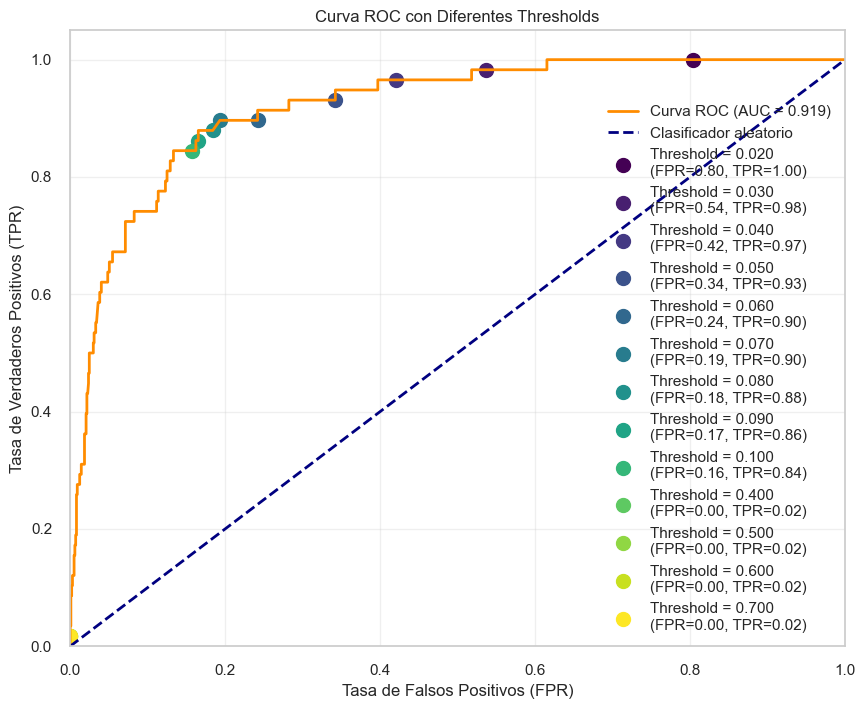

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(results_df['target'], results_df['predicted_prob'])
roc_auc = auc(fpr, tpr)

# Graficar curva ROC con algunos thresholds destacados
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador aleatorio')

# Marcar algunos thresholds específicos
threshold_points = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.4, 0.5, 0.6, 0.7]
colors = plt.cm.viridis(np.linspace(0, 1, len(threshold_points)))

for i, thresh in enumerate(threshold_points):
    idx = np.argmin(np.abs(thresholds - thresh))
    plt.scatter(fpr[idx], tpr[idx], color=colors[i], s=100, 
                label=f'Threshold = {thresh:.3f}\n(FPR={fpr[idx]:.2f}, TPR={tpr[idx]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Diferentes Thresholds')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

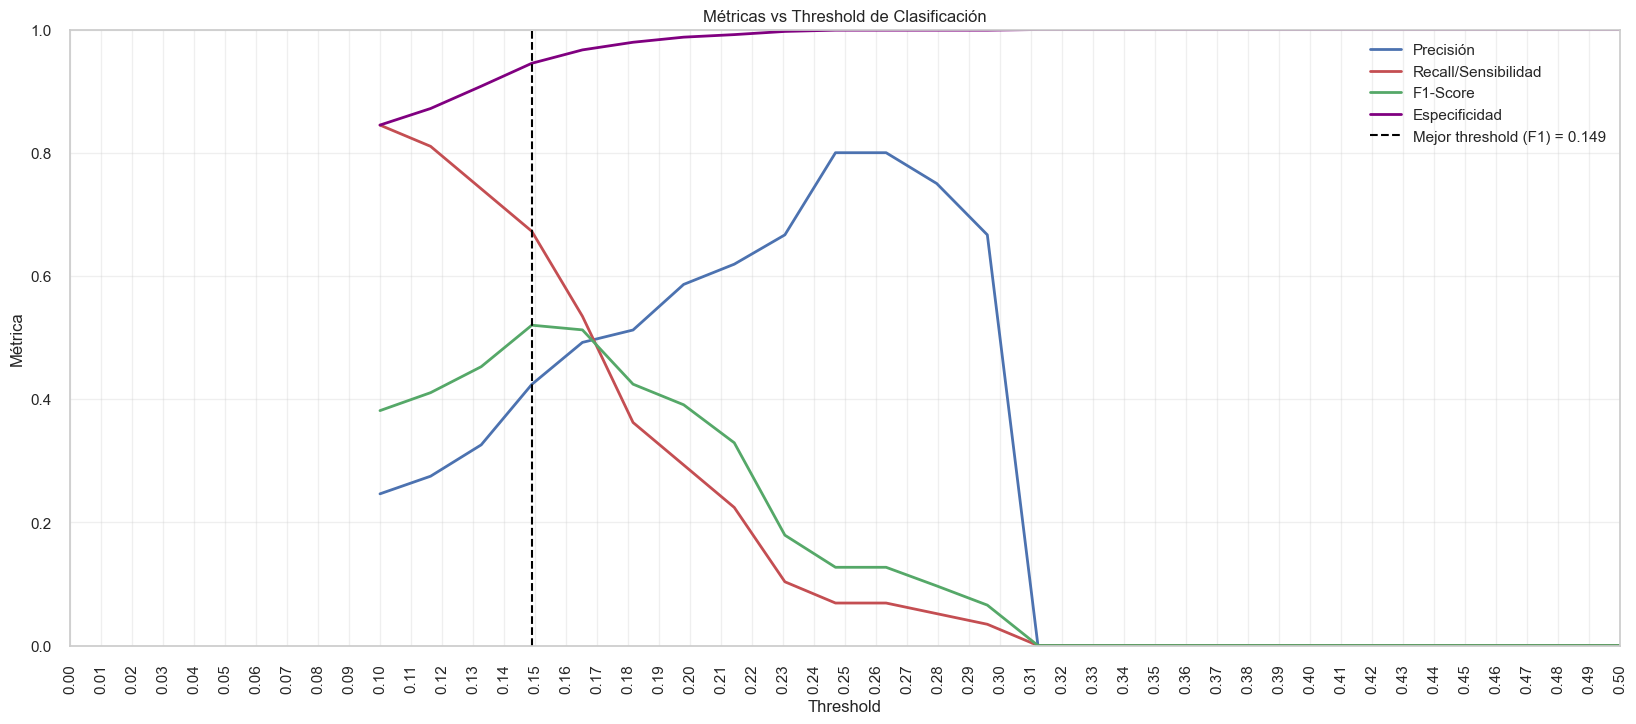

Mejor threshold por F1-score: 0.149


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from matplotlib.ticker import MultipleLocator

# Calcular métricas para diferentes thresholds
thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []
specificities = []

for thresh in thresholds:
    y_pred = (results_df['predicted_prob'] >= thresh).astype(int)
    precisions.append(precision_score(results_df['target'], y_pred, zero_division=0))
    recalls.append(recall_score(results_df['target'], y_pred))
    f1_scores.append(f1_score(results_df['target'], y_pred))
    
    # Especificidad (TNR)
    tn = np.sum((y_pred == 0) & (results_df['target'] == 0))
    fp = np.sum((y_pred == 1) & (results_df['target'] == 0))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)

# Graficar
plt.figure(figsize=(20, 8))
plt.plot(thresholds, precisions, 'b-', label='Precisión', linewidth=2)
plt.plot(thresholds, recalls, 'r-', label='Recall/Sensibilidad', linewidth=2)
plt.plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2)
plt.plot(thresholds, specificities, 'purple', label='Especificidad', linewidth=2)

# Mejor threshold por F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
plt.axvline(x=best_threshold, color='black', linestyle='--', 
            label=f'Mejor threshold (F1) = {best_threshold:.3f}')

plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('Métricas vs Threshold de Clasificación')
plt.legend()

# Cuadrícula cada 0.1 en el eje X
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.01))
plt.grid(True, alpha=0.3)
plt.xticks(rotation=90)
plt.ylim([0, 1])
plt.xlim([0, 0.5])
plt.show()

print(f"Mejor threshold por F1-score: {best_threshold:.3f}")


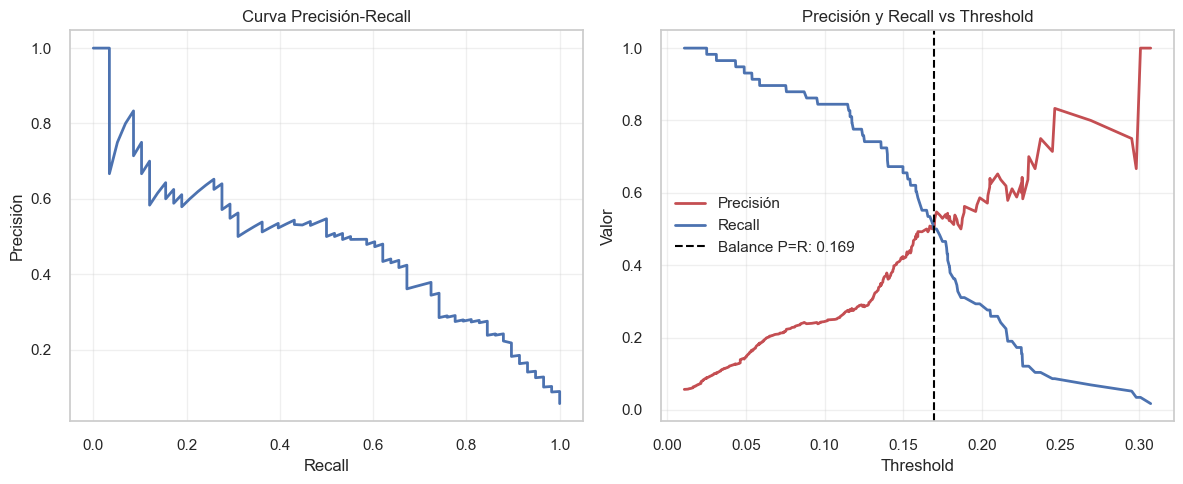

In [11]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(
    results_df['target'], results_df['predicted_prob']
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, 'b-', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva Precisión-Recall')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(thresholds_pr, precision[:-1], 'r-', label='Precisión', linewidth=2)
plt.plot(thresholds_pr, recall[:-1], 'b-', label='Recall', linewidth=2)

# Encontrar punto donde precisión = recall
diff = np.abs(precision[:-1] - recall[:-1])
balance_idx = np.argmin(diff)
balance_threshold = thresholds_pr[balance_idx]

plt.axvline(x=balance_threshold, color='black', linestyle='--',
            label=f'Balance P=R: {balance_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.title('Precisión y Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

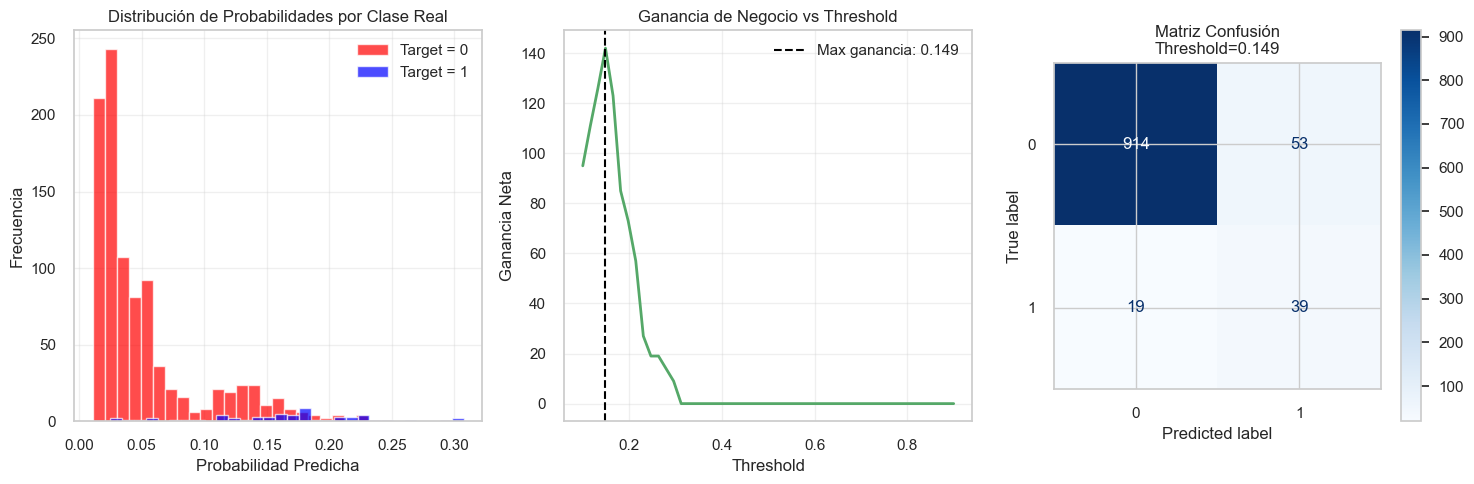

Threshold para máxima ganancia: 0.149


In [12]:
plt.figure(figsize=(15, 5))

# Distribución de probabilidades por clase real
plt.subplot(1, 3, 1)
plt.hist(results_df[results_df['target'] == 0]['predicted_prob'], 
         bins=30, alpha=0.7, label='Target = 0', color='red')
plt.hist(results_df[results_df['target'] == 1]['predicted_prob'], 
         bins=30, alpha=0.7, label='Target = 1', color='blue')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades por Clase Real')
plt.legend()
plt.grid(True, alpha=0.3)

# Calibrar threshold para maximizar ganancia de negocio
plt.subplot(1, 3, 2)
# Suponiendo costos/beneficios (ajusta según tu caso)
costo_fp = 1    # Costo de falso positivo
beneficio_tp = 5  # Beneficio de verdadero positivo

ganancias = []
for thresh in thresholds:
    y_pred = (results_df['predicted_prob'] >= thresh).astype(int)
    tp = np.sum((y_pred == 1) & (results_df['target'] == 1))
    fp = np.sum((y_pred == 1) & (results_df['target'] == 0))
    ganancia = (tp * beneficio_tp) - (fp * costo_fp)
    ganancias.append(ganancia)

best_ganancia_idx = np.argmax(ganancias)
best_threshold_ganancia = thresholds[best_ganancia_idx]

plt.plot(thresholds, ganancias, 'g-', linewidth=2)
plt.axvline(x=best_threshold_ganancia, color='black', linestyle='--',
            label=f'Max ganancia: {best_threshold_ganancia:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Ganancia Neta')
plt.title('Ganancia de Negocio vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

# Matriz de confusión con mejor threshold
plt.subplot(1, 3, 3)
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_best = (results_df['predicted_prob'] >= best_threshold_ganancia).astype(int)
cm = confusion_matrix(results_df['target'], y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=plt.gca(), cmap='Blues')
plt.title(f'Matriz Confusión\nThreshold={best_threshold_ganancia:.3f}')

plt.tight_layout()
plt.show()

print(f"Threshold para máxima ganancia: {best_threshold_ganancia:.3f}")

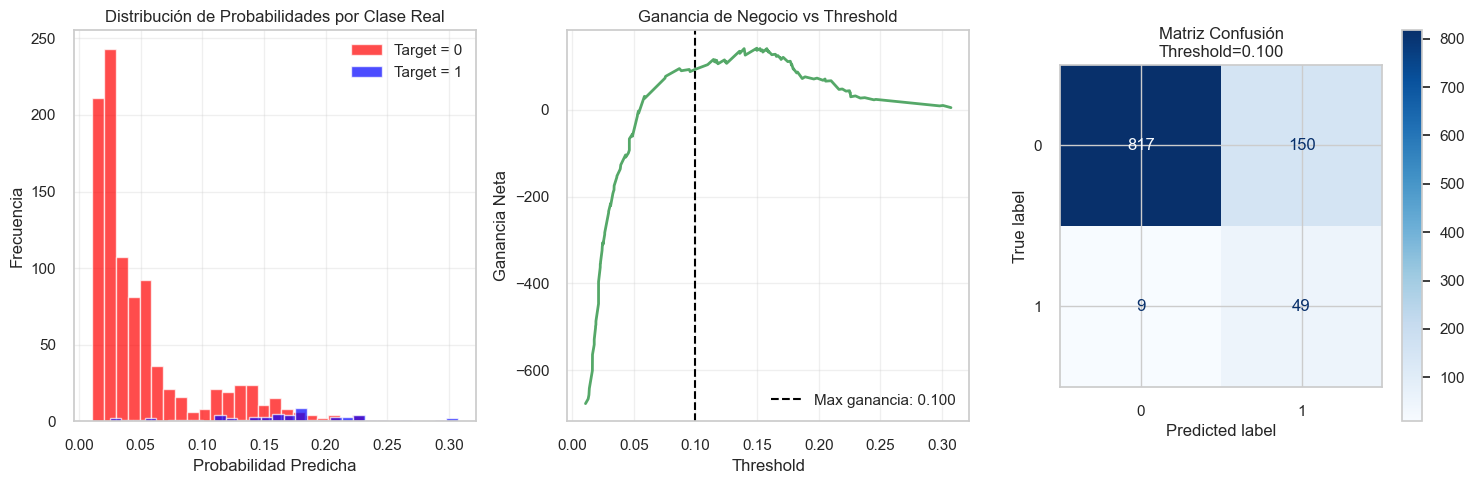

Threshold forzado: 0.100


In [17]:
plt.figure(figsize=(15, 5))

# Distribución de probabilidades por clase real
plt.subplot(1, 3, 1)
plt.hist(results_df[results_df['target'] == 0]['predicted_prob'], 
         bins=30, alpha=0.7, label='Target = 0', color='red')
plt.hist(results_df[results_df['target'] == 1]['predicted_prob'], 
         bins=30, alpha=0.7, label='Target = 1', color='blue')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades por Clase Real')
plt.legend()
plt.grid(True, alpha=0.3)

# Calibrar threshold para maximizar ganancia de negocio
plt.subplot(1, 3, 2)
# Suponiendo costos/beneficios (ajusta según tu caso)
costo_fp = 1    # Costo de falso positivo
beneficio_tp = 5  # Beneficio de verdadero positivo

ganancias = []
for thresh in thresholds:
    y_pred = (results_df['predicted_prob'] >= thresh).astype(int)
    tp = np.sum((y_pred == 1) & (results_df['target'] == 1))
    fp = np.sum((y_pred == 1) & (results_df['target'] == 0))
    ganancia = (tp * beneficio_tp) - (fp * costo_fp)
    ganancias.append(ganancia)

best_ganancia_idx = np.argmax(ganancias)
best_threshold_ganancia = thresholds[best_ganancia_idx]
best_threshold_ganancia = 0.1

plt.plot(thresholds, ganancias, 'g-', linewidth=2)
plt.axvline(x=best_threshold_ganancia, color='black', linestyle='--',
            label=f'Max ganancia: {best_threshold_ganancia:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Ganancia Neta')
plt.title('Ganancia de Negocio vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

# Matriz de confusión con mejor threshold
plt.subplot(1, 3, 3)
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_best = (results_df['predicted_prob'] >= best_threshold_ganancia).astype(int)
cm = confusion_matrix(results_df['target'], y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=plt.gca(), cmap='Blues')
plt.title(f'Matriz Confusión\nThreshold={best_threshold_ganancia:.3f}')

plt.tight_layout()
plt.show()

print(f"Threshold forzado: {best_threshold_ganancia:.3f}")

In [21]:
best_h2o_model.model_id = "h2o_automl_model"

# Guardar el mejor modelo
model_path = h2o.save_model(model=best_h2o_model, path='../models/', force=True)
print(f"Modelo guardado en: {model_path}")


Modelo guardado en: /Users/luis.caporal/Documents/Master - TEC/9. MLOps/MNA_MLOps_Equipo12/notebooks/StackedEnsemble_BestOfFamily_1_AutoML_13_20251107_135752
